In [89]:
%matplotlib inline

import os
import h5py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

from scipy import stats as scipystats
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
from analysis.models.vr import RatCAVESession
from analysis.plots.placecells.F02_AB_cells import all_AB_cells, shift_plot, single_unit_plot
from analysis.plots.trajectory import arena_vs_animal_positions
from analysis.plots.placecells.utils import get_figure_size
from analysis.plots.placecells.draw import draw_occupancy, draw_place_field, draw_place_firing
from analysis.models.analytics import place_field_2D

from functools import reduce # only in Python 3

import nbimporter
from Utils import get_metrics, get_colors
from analysis.processing.utils import get_sessions_list, create_symlinks

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [463]:
color_a, color_b, color_c, color_d, color_e = get_colors()

reports_folder = '/home/andrey/storage2/andrey/data/projects/24_shift/analysis_15'
where = '/home/andrey/storage2/andrey/data/processed'
animals = ['003281', '003282', '003908', '003909']

# Split place firing in chunks / paths

In [345]:
sources = [
    ('003282', '2019-11-21_21-58-48', 7, 9),
    ('003282', '2019-11-24_20-06-11', 4, 10),
    ('003282', '2019-12-02_17-51-29', 5, 10),
    ('003909', '2020-03-27_18-41-37', 2, 11),
    ('003909', '2020-03-27_18-41-37', 6, 7)
]

sources = []
selected_folder = '/home/andrey/storage2/andrey/data/projects/24_shift/fields_15_stable_firing'
for filename in os.listdir(selected_folder):
    names = filename.split('.')[0].split('_')
    sources.append([names[0], '%s_%s' % (names[1], names[2]), int(names[3]), int(names[4])])

sources

[['003909', '2020-03-27_18-41-37', 6, 7],
 ['003909', '2020-03-27_18-41-37', 2, 11],
 ['003282', '2019-12-02_17-51-29', 5, 10],
 ['003282', '2019-11-24_20-06-11', 4, 10],
 ['003282', '2019-11-21_21-58-48', 7, 9],
 ['003282', '2019-11-21_21-58-48', 3, 6],
 ['003282', '2019-11-18_10-35-43', 3, 14],
 ['003282', '2019-11-18_10-35-43', 3, 8],
 ['00910', '2019-07-22_22-05-31', 5, 4],
 ['00908', '2019-07-21_17-29-37', 3, 5],
 ['00908', '2019-07-12_17-32-40', 3, 10],
 ['00908', '2019-07-11_08-24-01', 3, 6]]

In [346]:
results = []


for source in sources:
    h5file = os.path.join('/home/andrey/storage2/andrey/data/processed/', source[0], source[1], 'all.h5')

    with h5py.File(h5file, 'r') as f:
        trajectory = np.array(f['animal_trajectory'])
        A_idxs = np.array(f['A_indexes'])
        B_idxs = np.array(f['B_indexes'])
        running_idxs = np.array(f['running_idxs'])[0]

        unit_name = '%s_%s' % (source[2], source[3])
        unit_idxs = np.array(f['units'][unit_name]['trajectory_indexes'])

        COMa = np.array(f['units'][unit_name]['A_fields_COMs'])
        COMb = np.array(f['units'][unit_name]['B_fields_COMs'])


    # times and positions when the unit spiked = spiketrain
    spike_times = trajectory[unit_idxs]

    # ------- splitting spiketrain into burtsts separated by time threshold (2 seconds) ---------

    idxs_of_chunks_idxs = []
    chunk = []
    delta_threshold = 2  # seconds

    for i, delta in enumerate(np.diff(spike_times[:, 0])):
        if delta < delta_threshold:
            chunk.append(i)
        else:
            if len(chunk) > 0:
                chunk.append(i)
                idxs_of_chunks_idxs.append(list(chunk))
            chunk = []

    if len(chunk) > 0:
        idxs_of_chunks_idxs.append(list(chunk))

    spike_idxs = []
    for chunk in idxs_of_chunks_idxs:
        spike_idxs.append(unit_idxs[np.array(chunk)])


    # filter out bursts having less than 20 spikes
    spike_idxs_filt = [x for x in spike_idxs if len(x) > 20]

    # remove bursts outside of region of interest (e.g. when dark)
    AB_idxs = np.union1d(A_idxs, B_idxs)
    sp_count = len([x for x in spike_idxs_filt if len(np.intersect1d(AB_idxs, x)) > 0])
    spike_idxs_filt = spike_idxs_filt[:sp_count]


    # --------- average angles for each burst = spike path ------------

    def angle_between(p1, p2):
        ang1 = np.arctan2(*p1[::-1])
        ang2 = np.arctan2(*p2[::-1])
        return np.rad2deg( (2*np.pi + (ang1 - ang2)) )  

    # Option 1: MEAN of angles between spike locations
    all_angles = []
    for burst in spike_idxs_filt:
        angles = []

        for i, idx in enumerate(burst[:-1]):
            p1 = np.array((trajectory[burst[i]][1], trajectory[burst[i]][2]))
            p2 = np.array((trajectory[burst[i + 1]][1], trajectory[burst[i + 1]][2]))
            angle = angle_between(p2 - p1, (1, 0))
            if len(angles) > 0:
                angle = angle if np.abs(np.mean(angles) - angle) < np.abs(np.mean(angles) - angle % 360) else angle % 360
            angles.append(angle)

        all_angles.append(angles)

    angle_means = [np.mean([x for x in burst_angles if x % 360 > 0]) for burst_angles in all_angles]

    # Option 2: angle between the beginning and the end (a bit better?)
    angle_means = []

    for burst in spike_idxs_filt:
        p_beg = np.array((trajectory[burst[:5]][:, 1].mean(), trajectory[burst[:5]][:, 2].mean()))
        p_end = np.array((trajectory[burst[-5:]][:, 1].mean(), trajectory[burst[-5:]][:, 2].mean()))
        angle_means.append(angle_between(p_end - p_beg, (1, 0)) % 360)
    angle_means = np.array(angle_means)

    # ---------- Y-position for each burst ---------------

    burst_positions = []
    for burst in spike_idxs_filt:
        burst_positions.append(np.median(trajectory[burst][:, 2]))
    burst_positions = np.array(burst_positions)

    # ---------- Y-center of mass for each burst ---------------

    burst_COMs = []
    for burst in spike_idxs_filt:
        spk_A_idxs = np.intersect1d(A_idxs, burst)
        spk_B_idxs = np.intersect1d(B_idxs, burst)

        burst_COMs.append(COMa[0][2] if len(spk_A_idxs) > len(spk_B_idxs) else COMb[0][2])
    burst_COMs = np.array(burst_COMs)
    
    
    # --------- pack everything into a dict and save into results ----------
    
    data = {
        'trajectory': trajectory,
        'A_idxs': A_idxs,
        'B_idxs': B_idxs,
        'running_idxs': running_idxs,
        'unit_idxs': unit_idxs,
        'COMa': COMa,
        'COMb': COMb,
        'sp_count': sp_count,
        'spike_idxs_filt': spike_idxs_filt,
        'all_angles': all_angles,
        'angle_means': angle_means,
        'burst_positions': burst_positions,
        'burst_COMs': burst_COMs
    }
    
    results.append(data)

# Plot individual paths

In [359]:
fig = figure(figsize=(16, 8))

unit = 1

trajectory = results[unit]['trajectory']
A_idxs = results[unit]['A_idxs']
B_idxs = results[unit]['B_idxs']
running_idxs = results[unit]['running_idxs']
sp_count = results[unit]['sp_count']
spike_idxs_filt = results[unit]['spike_idxs_filt']
angle_means = results[unit]['angle_means']
burst_positions = results[unit]['burst_positions']
burst_COMs = results[unit]['burst_COMs']
COMa = results[unit]['COMa']
COMb = results[unit]['COMb']


limits = get_figure_size(trajectory[:, 1:3], border=0.05)
colors = cm.rainbow(np.linspace(0, 1, sp_count))

A_all_idxs = np.intersect1d(A_idxs, running_idxs)
ax = fig.add_subplot(121)
ax.set_xlabel('X, m')
ax.set_ylabel('Y, m')
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.grid(True)
ax.axhline(COMa[0][2], color=color_b)
ax.scatter(trajectory[A_all_idxs][:, 1], trajectory[A_all_idxs][:, 2], alpha=0.05, color='#B4B8AB')  # occupancy

selected = 18

for i, spike_path in enumerate(spike_idxs_filt):
    spk_idxs = np.intersect1d(A_idxs, spike_path)
    if len(spk_idxs) > 0 and i == selected:
        ax.scatter(trajectory[spk_idxs][:, 1], trajectory[spk_idxs][:, 2], color=colors[i])
        ax.text(-1, 1, "%0.1f" % angle_means[i], fontsize=14)
        ax.axhline(burst_positions[i], color=color_a)

B_all_idxs = np.intersect1d(B_idxs, running_idxs)
ax = fig.add_subplot(122)
ax.set_xlabel('X, m')
ax.set_ylabel('Y, m')
ax.set_xlim(limits[0], limits[1])
ax.set_ylim(limits[2], limits[3])
ax.grid(True)
ax.axhline(COMb[0][2], color=color_b)
ax.scatter(trajectory[B_all_idxs][:, 1], trajectory[B_all_idxs][:, 2], alpha=0.05, color='#B4B8AB')  # occupancy

for i, spike_path in enumerate(spike_idxs_filt):
    spk_idxs = np.intersect1d(B_idxs, spike_path)
    if len(spk_idxs) > 0 and i == selected:
        ax.scatter(trajectory[spk_idxs][:, 1], trajectory[spk_idxs][:, 2], color=colors[i])
        ax.text(-1, 1, "%0.1f" % angle_means[i], fontsize=14)
        ax.axhline(burst_positions[i], color=color_a)

# Angle vs Y-position

In [352]:
fig = figure(figsize=(6, 8))

ax = fig.add_subplot(111)
ax.set_xlim(0, 360)
ax.grid()
ax.axhline(0)

for data in results:
    #x = data['angle_means'] % 180
    #y = data['burst_positions'] - (data['COMb'][0][2] + data['COMa'][0][2]) / 2
    
    #x -= 90
    #x = np.array([x_i * np.sign(x_i)*(-1) for x_i in x])
    #x += 90
    
    #ax.scatter(x, y, color=color_a)
    #ax.scatter(data['angle_means'], data['burst_positions'] - data['burst_COMs'], color=color_a)
    ax.scatter(data['angle_means'], data['burst_positions'] - (data['COMb'][0][2] + data['COMa'][0][2]) / 2, color=color_b)


In [353]:
slope, intercept, r_value, p_value, std_err = scipystats.linregress(data['angle_means'], data['burst_positions'] - (data['COMb'][0][2] + data['COMa'][0][2]) / 2)

r_value, p_value

(0.3159663500210976, 0.7953426520618753)

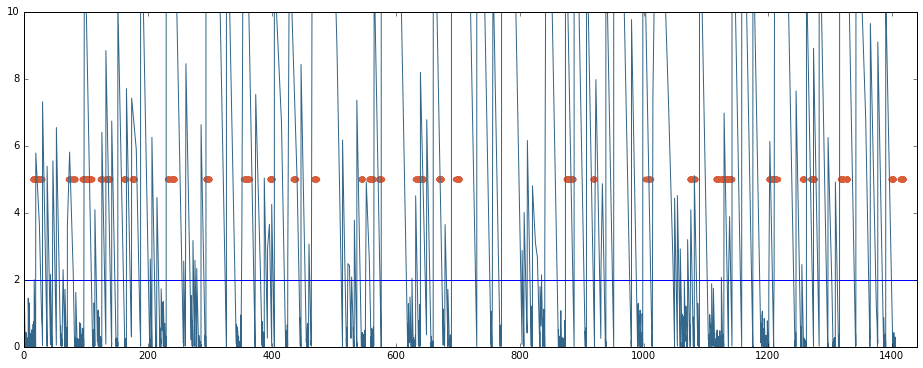

In [103]:
# flatten bursts into single array of spike (trajectory) indexes
spike_idxs_flat = reduce(lambda a,b : np.concatenate([a, b]), spike_idxs_filt)
traj_times_norm = trajectory[:, 0] - trajectory[0][0]

fig = figure(figsize=(16, 6))

ax = fig.add_subplot(111)
ax.plot(spike_times[:-1, 0] - spike_times[0][0], np.diff(spike_times[:, 0]), color=color_a)
ax.scatter(traj_times_norm[spike_idxs_flat], np.ones(len(spike_idxs_flat)) + 4, color=color_b)
ax.set_ylim(0, 10)
ax.set_xlim(0, 1440)
ax.axhline(2)

# Gaussian Convolution

In [466]:
from scipy import signal
from matplotlib.gridspec import GridSpec

bins = 200
space_min = -1
space_max = 1

def get_empty_space():
    v_x = np.linspace(space_min, space_max, bins)
    v_y = np.zeros(bins)
    return np.array([[x, y] for x, y in zip(v_x, v_y)])

gauss_bins = 101
pos_std = 0.15
gauss_std = pos_std / ((space_max - space_min)/bins)

v_mean = 0
b_mean_left = -0.15
b_mean_right = b_mean_left + 0.3

# ----- visual input -------
v_win = get_empty_space()
idx = int(np.abs(v_win[:, 0] - v_mean).argmin() - (gauss_bins - 1)/2)
v_win[idx:idx + gauss_bins, 1] = signal.gaussian(gauss_bins, std=gauss_std)

# ----- boundary input in A -------
b_left_win = get_empty_space()
idx = int(np.abs(b_left_win[:, 0] - b_mean_left).argmin() - (gauss_bins - 1)/2)
b_left_win[idx:idx + gauss_bins, 1] = signal.gaussian(gauss_bins, std=gauss_std)

# ----- boundary input in B -------
b_right_win = get_empty_space()
idx = int(np.abs(b_right_win[:, 0] - b_mean_right).argmin() - (gauss_bins - 1)/2)
b_right_win[idx:idx + gauss_bins, 1] = signal.gaussian(gauss_bins, std=gauss_std)

# ----- SUM of boundary inputs
x_f = b_left_win[:, 0]
y_f = b_left_win[:, 1] + b_right_win[:, 1]
f_win = np.array([[x, y] for x, y in zip(x_f, y_f)])


# ----- SUM of boundary inputs
x_f = b_left_win[:, 0]
y_f = b_left_win[:, 1] + b_right_win[:, 1]
f_win = np.array([[x, y] for x, y in zip(x_f, y_f)])


c_x = v_win[:, 0]
c_y = np.convolve(v_win[:, 1], f_win[:, 1], mode='same')
f_cvd = np.array([[x, y] for x, y in zip(c_x, c_y)])


# ----- FIGURE ----------
fig = figure(figsize=(16, 10))

gs = GridSpec(4, 1)
lim_left = -0.6
lim_right = 0.6

ax = fig.add_subplot(gs[:2, :])
ax.plot(v_win[:, 0], v_win[:, 1], color=color_d, label='Visual input')
ax.plot(b_left_win[:, 0], b_left_win[:, 1], color=color_a, label='Boundary input in A')
ax.plot(b_right_win[:, 0], b_right_win[:, 1], color=color_a, label='Boundary input in B')
ax.axvline(v_mean, color=color_d)
ax.axvline(b_mean_left, color=color_a, linestyle='dashed')
ax.axvline(b_mean_right, color=color_a, linestyle='dashed')
ax.set_xlim(lim_left, lim_right)
ax.set_ylim(0, 1.5)
ax.set_ylabel('Firing probability, AU', fontsize=14)
ax.set_title('Maximum cumulative activity when boundary spanned symmetrically rel. to visual inputs', fontsize=18)
ax.legend(loc='upper right')
ax.text(lim_left + 0.05, 1.3, 'std = %.2f m' % pos_std, fontsize=14)


ax = fig.add_subplot(gs[2, :])
ax.plot(f_win[:, 0], f_win[:, 1], color=color_a, label='SUM of boundary inputs')
ax.axvline(v_mean, color=color_d)
ax.axvline(b_mean_left, color=color_a, linestyle='dashed')
ax.axvline(b_mean_right, color=color_a, linestyle='dashed')
ax.set_xlim(lim_left, lim_right)
ax.set_ylim(0, 1.5)
ax.set_ylabel('Firing probability, AU', fontsize=14)
ax.legend(loc='upper right')


ax = fig.add_subplot(gs[3, :])
ax.plot(f_cvd[:, 0], f_cvd[:, 1], color=color_c, label='Convolution of visual and boundary inputs')
ax.set_xlim(lim_left, lim_right)
ax.axvline(v_mean, color=color_d)
ax.axvline(b_mean_left, color=color_a, linestyle='dashed')
ax.axvline(b_mean_right, color=color_a, linestyle='dashed')
ax.set_xlabel('Arena position, m', fontsize=14)
ax.legend(loc='upper right')

filename = "visual_boundary_convolution_%s.png" % pos_std
fig.savefig(os.path.join(os.path.join(reports_folder), filename))